# <a href="https://thetahat.ru/courses/ph-ds-2024-aut">Phystech@DataScience</a>
## Домашнее задание 6

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков можно использовать без ограничений.**

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

<b><font color="blue">Легкая часть</font></b> (достаточно на "хор"):
* 30 баллов &mdash; все задания выполнены без ошибок, простая валидация модели на тестовой выборке
* 20 баллов &mdash; в каждом эксперименте присутствует подбор гиперпараметров с применением кросс-валидации


<b><font color="orange">Cложная часть</font></b> (необходимо на "отл"):
* 20 баллов &mdash; при подборе гиперпараметров использован `Pipeline`

-----

In [293]:
# Bot check

# HW_ID: phds_hw6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [294]:
!pip install feature_engine

In [295]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

# Настройки и стили
plt.style.use('seaborn-dark-palette') #выберите единый стиль для ваших графиков
%matplotlib inline
warnings.filterwarnings('ignore')

# Библиотеки для работы со временем
from datetime import datetime, date, time, timedelta
from calendar import monthrange

# Библиотеки для предобработки
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from feature_engine.encoding import MeanEncoder #возможно придется сделать !pip install feature_engine

# Классификаторы
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Рекомендованные регрессоры для физиков
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.svm import SVR

### Задача 1

При каждом обучении модели не забывайте производить подбор гиперпараметров для достижения наилучшей точности. Там, где возможна утечка таргета &mdash; старайтесь использовать `Pipeline`.

Рекомендуется также изучить ячейку с импортами. Возможно, там вы найдёте если не подсказки, то полезные инструменты для работы с данными.

---

#### Профиль физика

Наборы данных содержат записи о землетрясениях с 1/1/2001 по 1/1/2023.



**Датасет можно найти по следующей ссылке**: [Earthquake Significant Prediction](https://www.kaggle.com/datasets/artemkhakimov/earthquake-significant-prediction/data).

##### Описание фичей

- **title**: название землетрясения
- **min&max magnitude**: минимальная и максимальная зарегистрированная магнитуда землетрясения
- **date_time**: дата и время
- **cdi**: максимальная зарегистрированная интенсивность для диапазона событий
- **mmi**: максимальная теоретическая интенсивность для события
- **tsunami**: «yes» для событий в океанических регионах и «no» в противном случае
- **net**: идентификатор поставщика данных. Определяет сеть, которая считается предпочтительным источником информации для этого события
- **nst**: общее количество сейсмических станций, используемых для определения местоположения землетрясения
- **dmin**: горизонтальное расстояние от эпицентра до ближайшей станции
- **gap**: самый большой азимутальный зазор между азимутально соседними станциями (в градусах). В целом, чем меньше это число, тем надежнее вычисленное горизонтальное положение землетрясения. Места землетрясений, в которых азимутальный зазор превышает 180 градусов, обычно имеют большую неопределенность местоположения и глубины
- **magType**: метод или алгоритм, используемый для расчета предпочтительной магнитуды события
- **depth**: глубина, на которой начинается землетрясение
- **latitude/longitude**: система координат, с помощью которой можно определить и описать положение или местоположение любого места на поверхности Земли
- **location**: местоположение в пределах страны
- **continent**: континент страны, на которой произошло землетрясение
- **country**: пострадавшая страна
- **sig**: целевая переменная &mdash; число, описывающее, насколько значительным является событие. Большие числа указывают на более разрушительные землетрясения



**Метрикой в этой задаче является RMSE !**

In [296]:
from sklearn.metrics import root_mean_squared_error as RMSE

##### 1. Обучение модели без предобработки и с обработкой категориальных признаков

Cкачайте и выведите датасет

Теперь посмотрите на возможные типы данных в датасете

Сравним качество получаемых моделей в двух случаях: первую модель обучим на данных без учета категориальных признаков, а для обучения второй модели каждый категориальный признак преобразуем наиболее подходящим методом: OneHotEncoding'ом, LabelEncoding'ом или MeanEncoding'ом. Используйте *интерпретируемую* модель - например, линейную регрессию с регуляризацией или решающее дерево. Это в дальнейшем нам пригодится. Также выберите метрику качества на ваше усмотрение.

**Обучим первую модель без обработки признаков**

**Теперь подготовим данные для второй модели**

Сначала определим, какой метод подходит для каждого из категориальных признаков &mdash; для этого нужно понять количество уникальных значени в каждом.

Перед тем как начать кодировать категориальные признаки, напомним подходящие методы: OneHotEncoding &mdash; для малого количества неупорядоченных меток, LabelEncoding &mdash; для упорядоченных меток (может быть, для некоторых столбцов лучше задать лейблы вручную), MeanEncoding &mdash;  большое количество неупорядоченных меток классов. Также в лекции упоминались Binary- и FrequencyEncoding. В случаях, где возможна утечка таргета, напишите пояснение что вы собираетесь использовать для каждого столбца, а сам метод применяйте уже внутри пайплайна при подборе гиперпараметров.

In [297]:
# Не забываем также привести столбец со временем к формату времени


Напишите, какие вы признаки преобразовали, каким методом и почему


**Ответ:**

Обучите модель на полученных данных, сравните результаты с предыдущим экспреиментом. Да, подбор гиперпараметров и пайплайн здесь тоже желательны

##### 2. Feature engineering
В этом разделе вам предлагается создать новые признаки на основе существующих. Используйте методы, рассказанные на лекции.

*Подсказка 1: связь величины SIG с временем.* Ниже приведён пример того как можно отобразить устреднённое значение таргета по месяцам. На его основе вы можете посмотреть поведение данных за другой промежуток времени, а также посмотреть на другие статистики. Вдруг это поможет сгенерировать новые осмысленные признаки, связанные с выявленной периодичностью или чем-то ещё.

*Замечание.* Метод `pd.Grouper` в библиотеке pandas используется для группировки данных по определенному ключу и частоте. Это особенно полезно для временных рядов, где необходимо агрегировать данные по определенным временным интервалам.

Основные параметры
1. `key`: Строка или объект, указывающий, по какому столбцу или индексу
группировать данные.
2. `freq`: Строка, указывающая частоту группировки. Поддерживаются различные частоты, такие как минуты, часы, дни, месяцы и т.д.

Поддерживаемые частоты (`freq`)
* T: Минуты
* H: Часы
* D: Дни
* W: Недели
* M: Месяцы
* Q: Кварталы
* A: Годы

**Поэкспериментируйте, и сделайте выводы, какие признаки из времени вы считаете важными**

**Вывод:**

*Подсказка 2: геоаналитика*

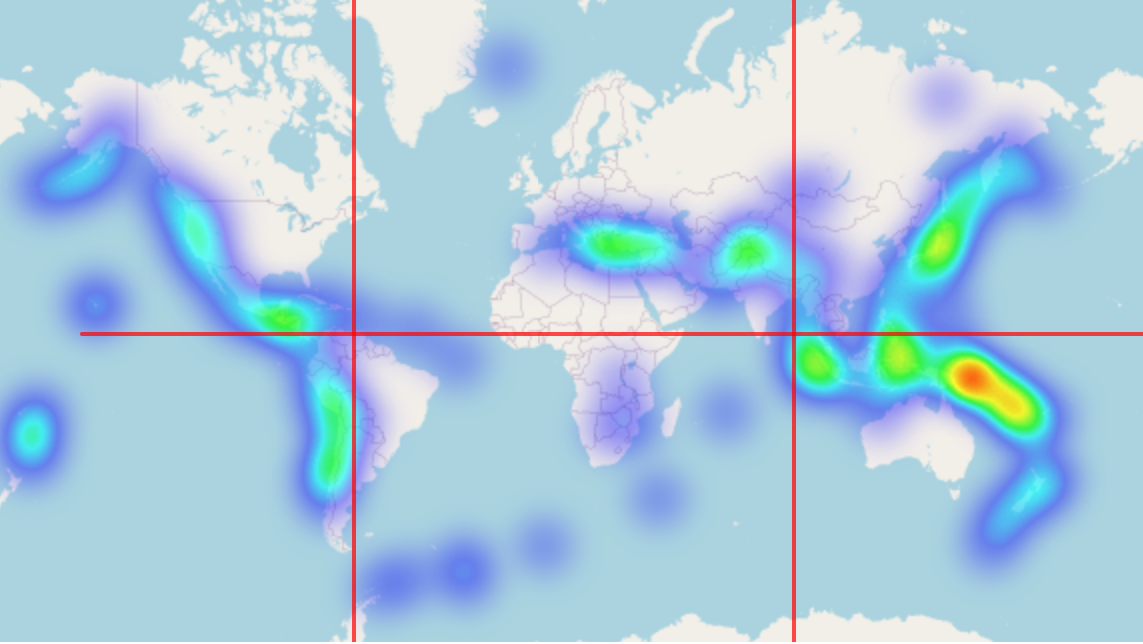

Не секрет, что есть районы с более сильной сейсмической активностью, есть с более слабой. Что если попробовать помочь модели в работе с координатами &mdash; подсказать ей более активные участки? В вашем распоряжении есть колонки со значением широты и долготы.

*Ваши фичи*

Пропробуйте самостоятельно сгенерировать несколько признаков. Не забывайте писать пояснения к вашим действиям.

**Пояснения:** <...>

##### 3. Обучение третьей модели

Обучите модель на обновленном датасете. Не забудьте про нормировку даных и подбор гиперпараметров. Сравните результаты с предыдущими экспериментами.

##### 4. Анализ зависимостей

Теперь вам необходимо попробовать посмотреть на сами модели. Выведите и проанализируйте коэффициенты, если это линейная модель; если это решающее дерево, то визуализируйте его структуру и посмотрите на узлы. Попробуйте что-то понять о данных и о зависимости признаков и таргета исходя из наилучшей модели. Оцениваются хорошая визуализация и выводы.

##### 5. Отбор признаков.

На лекции было рассказано о нескольких методах отбора признаков. Воспользуйтесь одним или несколькими из них, отберите наиболее важные признаки. Удобно отображать важность признаков при помощи гистограмм. Вновь произведите обучение и сравните полученные результаты с прошлыми экспериментами.

##### 6. Сделайте общий вывод по задаче

---

#### Профиль биология

Вам предстоит предсказать исход для животных, покидающих Центр животных. Эти исходы включают: Появление новых хозяев, Смерть, Эвтаназию, Возврат владельцу и Передачу (Adoption, Died, Euthanasia, Return to owner, and Transfer).


 Датасет можно найти по следующей ссылке (вам нужна только папка train): [Shelter Animal Outcomes](https://www.kaggle.com/competitions/shelter-animal-outcomes).

##### Основные характеристики животных

- **AnimalID**: уникальный идентификатор животного
- **Name**: имя животного
- **DateTime**: дата и время
- **OutcomeType**: тип исхода (например, Появление новых хозяев, Смерть, Эвтаназия, Возврат владельцу, Передача)
- **OutcomeSubtype**: подтип исхода
- **AnimalType**: тип животного (например, кошка, собака)
- **SexuponOutcome**: пол животного на момент исхода
- **AgeuponOutcome**: возраст животного на момент исхода
- **Breed**: порода животного
- **Color**: цвет животного

**Метрикой в этой задаче является LogLoss !**

 Формула тогда будет следующей:

$$
\text{logloss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{M} y_{ij} \log(p_{ij}),
$$

где:
- \( N \) — количество животных в тестовом наборе,
- \( M \) — количество исходов,
- \( log \) — натуральный логарифм,
- \( y_{ij} \) равно 1, если наблюдение \( i \) принадлежит исходу \( j \), и 0 в противном случае,
- \( p_{ij} \) — предсказанная вероятность того, что наблюдение \( i \) принадлежит исходу \( j \).


In [298]:
from sklearn.metrics import log_loss

Cкачайте и выведите датасет

In [299]:
df = pd.read_csv("/content/shelter_animal_outcomes.csv", index_col='AnimalID')
df.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26729 entries, A671945 to A706629
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            19038 non-null  object
 1   DateTime        26729 non-null  object
 2   OutcomeType     26729 non-null  object
 3   OutcomeSubtype  13117 non-null  object
 4   AnimalType      26729 non-null  object
 5   SexuponOutcome  26728 non-null  object
 6   AgeuponOutcome  26711 non-null  object
 7   Breed           26729 non-null  object
 8   Color           26729 non-null  object
dtypes: object(9)
memory usage: 2.0+ MB


Ни одного числового признака! Ситуация осложняется тем, что не все столбцы могут быть "в лоб" преобразованы в числа.

##### 1. Предобработка

Приведём данные к более "рабочему" виду. Сначала преобразуем столбец возраста на момент выхода из приюта (`AgeuponOutcome`):

In [301]:
def apply_transform_dates(x):
    """
    Считывает строку вида 'N период' и возвращает число дней равное N * (к-во дней в периоде)

    Args:
        x (str): объект

    Returns:
        float: возраст животного в днях
    """
    if pd.isnull(x):
        return x
    num_val = float(x.split(" ")[0])
    if "year" in x.lower():
        return num_val *  365
    elif "month" in x.lower():
        return num_val *  30
    elif "week" in x.lower():
        return num_val *  7

df["AgeuponOutcome"] = df["AgeuponOutcome"].apply(apply_transform_dates)

Из столбца породы `Breed` выделим два признака: помесь/не помесь и  название породы. О регулярных выражениях (regex) можно почитать в интернете, например [тут](https://habr.com/ru/articles/349860/). Породы, которые встречаются редко, обозначим просто как "Rare".

In [302]:
# Создание колонки помесь/не помесь
df['Is_Mix'] = df['Breed'].str.contains('Mix', na=False)

# Уберите слово Mix из названий пород, т. к. для него мы выделили отдельный столбец
df['Breed'] = df['Breed'].str.replace('Mix', '', regex=True).str.strip()

# Убираем лишние символы при помощи regex
df['Breed'] = df['Breed'].str.replace(r'\s*Black\s*|\s*Tan\s*', '', regex=True)
df['Breed'] = df['Breed'].replace('/', '', regex=True)
df['Breed'] = df['Breed'].str.strip('/')
df['Breed'] = df['Breed'].str.split('/').str[0]

Давайте посмотрим на количество уникальных пород

In [303]:
unique_breeds = df['Breed'].unique()
print('количество уникальных пород:', len(unique_breeds))

количество уникальных пород: 1244


Видно что пород крайне много, давайте посмотрим сколько кого встречается, и попробуем оставить только более-менее распространенные породы

In [304]:
# Очистка редких пород
breed_counts = df['Breed'].value_counts()

freq_breed = 5 # укажите пороговое количество, начиная с которого породу будем считать редкой

common_breeds = breed_counts[breed_counts > freq_breed].index.tolist()
df['Breed'] = df['Breed'].apply(lambda x: 'Rare' if x not in common_breeds else x) # переименнуем породу в редкую

Преобразуйте столбец даты и времени. Можете добавить столбцы года, месяца, дня, часа, дня недели или любое их подмножество. Напоминаем, что библиотека pandas предоставляет для этого удобный функционал.

In [305]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.day_name()

Преобразуйте столбец пола (`SexuponOutcome`). Обратите внимание: помимо самого пола данный признак содержит информацию о стерилизации. Замените данный признак двумя столбцами:

In [306]:
sex_data = df['SexuponOutcome'].str.split(' ', n=2, expand=True)

df['Sterilized'] = sex_data[0]
df['Sex'] = sex_data[1]

Также можно не выбрасывать столбец кличек животных. В предсказании целевой переменной может помочь информация о его наличии или отсутствии. Сгенерируйте соответствующий признак:

In [307]:
df['HasName'] = df['Name'].notna()

In [308]:
df['OutcomeSubtype'].isnull().sum()

13612

In [309]:
df['AgeuponOutcome'].isnull().sum()

416

Обработайте пропуски в данных. Вспомните, какие методы обработки пропусков вы проходили в прошлом семестре. Объясните использование того или иного метода. Если будете удалять строки с пропусками, не забывайте что в столбце `Name` пропуски несут полезную информацию!

In [310]:
df['OutcomeSubtype'].fillna(df['OutcomeSubtype'].mode()[0], inplace=True)
df['Sterilized'].fillna(df['OutcomeSubtype'].mode()[0], inplace=True)
df['Sex'].fillna(df['OutcomeSubtype'].mode()[0], inplace=True)

In [311]:
df['AgeuponOutcome'].fillna(df['AgeuponOutcome'].mean(), inplace=True)

'OutcomeSubtype' это категориальный признак, пропуски заполнили наиболее частым значением, это позволяет сохранить распределение данных и избежать введения новых категорий.


'AgeuponOutcome' это числовой признак, пропуки заполнили средним, это позволяет сохранить центральную тенденцию данных.

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26729 entries, A671945 to A706629
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Name            19038 non-null  object        
 1   DateTime        26729 non-null  datetime64[ns]
 2   OutcomeType     26729 non-null  object        
 3   OutcomeSubtype  26729 non-null  object        
 4   AnimalType      26729 non-null  object        
 5   SexuponOutcome  26728 non-null  object        
 6   AgeuponOutcome  26729 non-null  float64       
 7   Breed           26729 non-null  object        
 8   Color           26729 non-null  object        
 9   Is_Mix          26729 non-null  bool          
 10  Year            26729 non-null  int32         
 11  Month           26729 non-null  int32         
 12  Day             26729 non-null  int32         
 13  Hour            26729 non-null  int32         
 14  DayOfWeek       26729 non-null  object        
 15 

In [313]:
def color_features(df):
    def get_second_color(x):
        return x[1] if len(x) == 2 else "Absent"

    s = df.Color

    return pd.DataFrame({
        "FirstColor": s.str.split("/").map(lambda x: x[0]),
        "SecondColor": s.str.split("/").map(get_second_color),
        "IsMultiColor": s.str.contains("/") | (s == "Tricolor")
    })


In [314]:
color_features(df)

,FirstColor,SecondColor,IsMultiColor
AnimalID,,,
A671945,Brown,White,True
A656520,Cream Tabby,Absent,False
A686464,Blue,White,True
A683430,Blue Cream,Absent,False
A667013,Tan,Absent,False
...,...,...,...
A702446,Brown Tabby,White,True
A718934,Brown Tabby,Absent,False
A698128,White,Tan,True


In [315]:
color_df = color_features(df)

df = pd.concat([df, color_df], axis=1)

df = df.drop(columns=['Color'])

df

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Is_Mix,Year,Month,Day,Hour,DayOfWeek,Sterilized,Sex,HasName,FirstColor,SecondColor,IsMultiColor
AnimalID,,,,,,,,,,,,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,Partner,Dog,Neutered Male,365.0,Shetland Sheepdog,True,2014,2,12,18,Wednesday,Neutered,Male,True,Brown,White,True
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,365.0,Domestic Shorthair,True,2013,10,13,12,Sunday,Spayed,Female,True,Cream Tabby,Absent,False
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,730.0,Pit Bull,True,2015,1,31,12,Saturday,Neutered,Male,True,Blue,White,True
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,21.0,Domestic Shorthair,True,2014,7,11,19,Friday,Intact,Male,False,Blue Cream,Absent,False
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,730.0,Lhasa ApsoMiniature Poodle,False,2013,11,15,12,Friday,Neutered,Male,False,Tan,Absent,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A702446,NaN,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,30.0,Domestic Shorthair,True,2015,5,14,11,Thursday,Intact,Male,False,Brown Tabby,White,True
A718934,NaN,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,90.0,Domestic Shorthair,True,2016,1,20,18,Wednesday,Spayed,Female,False,Brown Tabby,Absent,False
A698128,Zeus,2015-03-09 13:33:00,Adoption,Partner,Dog,Neutered Male,1460.0,Rare,True,2015,3,9,13,Monday,Neutered,Male,True,White,Tan,True


Решила ещё добавить функцию, чтобы разбить столбец цвета на конкретные признаки.

Кажется... готово! Впрочем, если есть желание и светлые идеи как модернизировать предложенную предобработку данных, их воплощение только приветствуется. Главное &mdash; не забывайте писать пояснения!

##### 2. Кодирование категориальных признаков

А мы перейдём к кодированию категориальных признаков. Напомним подходящие методы: OneHotEncoding &mdash; для малого количества неупорядоченных меток, LabelEncoding &mdash; для упорядоченных меток, MeanEncoding &mdash;  большое количество неупорядоченных меток классов. Также в лекции упоминались Binary- и FrequencyEncoding. В случае, если возможна утечка таргета, напишите пояснение что вы собираетесь использовать для каждого столбца, а сам метод применяйте уже внутри пайплайна при подборе гиперпараметров. Столбцы, которые не собираетесь использовать &mdash; удалите.

In [326]:
from sklearn.preprocessing import OneHotEncoder

features = ['Sex', 'Sterilized', 'AnimalType', 'FirstColor', 'SecondColor', 'IsMultiColor']

X = df[features]
y = df['OutcomeType']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Sex', 'Sterilized', 'AnimalType', 'FirstColor', 'SecondColor', 'IsMultiColor']
),
        ]
    )),
    ('classifier', DecisionTreeClassifier())
])


pipeline.fit(X_train, y_train)


y_pred_proba = pipeline.predict_proba(X_test)

encoder = OneHotEncoder()
y_test_encoded = encoder.fit_transform(y_test.values.reshape(-1, 1))
y_test_encoded = y_test_encoded.toarray()

logloss = log_loss(y_test_encoded, y_pred_proba)
print("Log-loss:", logloss)


Log-loss: 1.8011554017744715


все плохо((( изменим параметры

In [327]:
features = ['Sex', 'Sterilized', 'AnimalType', 'FirstColor', 'SecondColor', 'IsMultiColor']

X = df[features]
y = df['OutcomeType']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Sex', 'Sterilized', 'AnimalType', 'FirstColor', 'SecondColor', 'IsMultiColor']
),
        ]
    )),
    ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2))
])


pipeline.fit(X_train, y_train)


y_pred_proba = pipeline.predict_proba(X_test)

encoder = OneHotEncoder()
y_test_encoded = encoder.fit_transform(y_test.values.reshape(-1, 1))
y_test_encoded = y_test_encoded.toarray()

logloss = log_loss(y_test_encoded, y_pred_proba)
print("Log-loss:", logloss)


Log-loss: 1.0592300532248937


ура, стало лучше

##### 3. Обучение модели на датасете с закодированными признаками

Выберите и зафиксируйте семейство моделей, с которым будете проводить дальнейшие эксперименты. Используйте *интерпретируемую* модель &mdash; например, линейную регрессию с регуляризацией или решающее дерево. Это в дальнейшем нам пригодится.

В каждом эксперименте проводите подбор наилучшей модели путём подбора гиперпараметров. Во избежание утечки таргета используйте `sklearn.Pipeline`.

Для начала обучите модель на получившемся датасете.

In [325]:
#выше

##### 3. Feature engineering
Сгенерируйте новые признаки. Например, на основе даты и времени или возраста животных. Ниже приведён пример того как можно отобразить суммарную частоту смертельных исходов и эвтаназии по месяцам. На его основе вы можете посмотреть на аналогичные статистики за другой промежуток времени, по другим исходам или вообще по другим столбцам. Вдруг это поможет сгенерировать новые осмысленные признаки, связанные с выявленной периодичностью или чем-то ещё.

Также, возможно, более тщательное изучение описания датасета, понимание смысла тех или иных признаков, натолкнёт вас на другие идеи.

In [333]:
# Переводим в формат даты-времени
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Задаём периодичность
freq_type = "M" # укажите тут любую другую частоту

# Выделение смертельных исходов связанных с эвтаназией и с иными причинами
death_outcomes      = df[["DateTime", "OutcomeType"]].loc[(df['OutcomeType'] == 'Died')]
euthanasia_outcomes = df[["DateTime", "OutcomeType"]].loc[(df['OutcomeType'] == 'Euthanasia')]

# Группировка соответствующих подтаблиц по месяцам. Описание объекта `pd.Grouper` см. в замечании ниже
death_frequency_per_month = death_outcomes.groupby(pd.Grouper(key='DateTime', freq=freq_type)).value_counts()
euthanasia_frequency_per_month = euthanasia_outcomes.groupby(pd.Grouper(key='DateTime', freq=freq_type)).value_counts()

# Хотим сложить два исхода по соответствующим индексам.
# Но индексы в даннном случае представляют собой объекты pd.MultiIndex вида ('DateTime', 'Death') или ('DateTime', 'Euthanasia')
# Для сложения строк с одинаковыми датами нам нужны обычные индексы типа 'DateTime'. Сделаем это:
death_frequency_per_month.index = death_frequency_per_month.index.get_level_values('DateTime')
euthanasia_frequency_per_month.index = euthanasia_frequency_per_month.index.get_level_values('DateTime')

# Наконец складываем 2 объекта pd.Series
all_death_cases_per_month = death_frequency_per_month + euthanasia_frequency_per_month

# Можете убедиться, что всё корректно:
print('Первые две строки 1-го слагаемого\n', death_frequency_per_month[0:2], '\n')
print('Первые две строки 2-го слагаемого\n', euthanasia_frequency_per_month[0:2], '\n')
print('Первые две строки суммы\n', all_death_cases_per_month[0:2], '\n')


Первые две строки 1-го слагаемого
 DateTime
2013-10-31    12
2013-11-30     3
Name: count, dtype: int64 

Первые две строки 2-го слагаемого
 DateTime
2013-10-31    73
2013-11-30    49
Name: count, dtype: int64 

Первые две строки суммы
 DateTime
2013-10-31    85
2013-11-30    52
Name: count, dtype: int64 



*Замечание.* Метод `pd.Grouper` в библиотеке pandas используется для группировки данных по определенному ключу и частоте. Это особенно полезно для временных рядов, где необходимо агрегировать данные по определенным временным интервалам.

Основные параметры
1. `key`: Строка или объект, указывающий, по какому столбцу или индексу
группировать данные.
2. `freq`: Строка, указывающая частоту группировки. Поддерживаются различные частоты, такие как минуты, часы, дни, месяцы и т.д.

Поддерживаемые частоты (`freq`)
* T: Минуты
* H: Часы
* D: Дни
* W: Недели
* M: Месяцы
* Q: Кварталы
* A: Годы

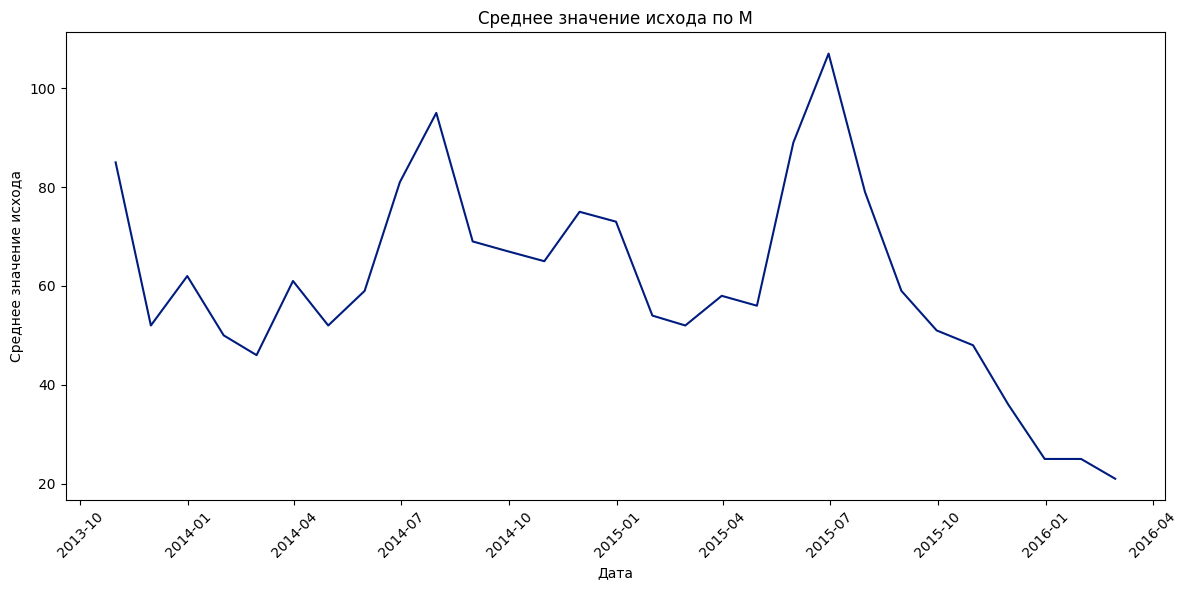

In [335]:
plt.figure(figsize=(12, 6))
plt.plot(all_death_cases_per_month)
plt.title('Среднее значение исхода по ' + str(freq_type))
plt.xlabel('Дата')
plt.ylabel('Среднее значение исхода')
plt.xticks(rotation=45)
plt.tight_layout()

In [336]:
df['Month'] = df['DateTime'].dt.to_period('M')
df = df.merge(all_death_cases_per_month.rename('DeathFrequency'), left_on='Month', right_index=True, how='left')


df['DeathFrequency'].fillna(0, inplace=True)

print(df.head())

             Name            DateTime      OutcomeType OutcomeSubtype  \
AnimalID                                                                
A671945   Hambone 2014-02-12 18:22:00  Return_to_owner        Partner   
A656520     Emily 2013-10-13 12:44:00       Euthanasia      Suffering   
A686464    Pearce 2015-01-31 12:28:00         Adoption         Foster   
A683430       NaN 2014-07-11 19:09:00         Transfer        Partner   
A667013       NaN 2013-11-15 12:52:00         Transfer        Partner   

         AnimalType SexuponOutcome  AgeuponOutcome  \
AnimalID                                             
A671945         Dog  Neutered Male           365.0   
A656520         Cat  Spayed Female           365.0   
A686464         Dog  Neutered Male           730.0   
A683430         Cat    Intact Male            21.0   
A667013         Dog  Neutered Male           730.0   

                               Breed  Is_Mix  Year  ... Day  Hour  DayOfWeek  \
AnimalID                     

##### 4. Обучение модели на датасете с дополнительными признаками
Проведите эксперимент

In [357]:
features = ['Sex', 'Sterilized', 'AnimalType', 'FirstColor', 'SecondColor', 'IsMultiColor','DeathFrequency']

X = df[features]
y = df['OutcomeType']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Sex', 'Sterilized', 'AnimalType', 'FirstColor', 'SecondColor', 'IsMultiColor','DeathFrequency']
),
        ]
    )),
    ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=2))
])


pipeline.fit(X_train, y_train)


y_pred_proba = pipeline.predict_proba(X_test)

encoder = OneHotEncoder()
y_test_encoded = encoder.fit_transform(y_test.values.reshape(-1, 1))
y_test_encoded = y_test_encoded.toarray()

logloss = log_loss(y_test_encoded, y_pred_proba)
print("Log-loss:", logloss)
importances = pipeline.named_steps['classifier'].feature_importances_
importances

Log-loss: 1.0530596999829567


array([6.87903182e-03, 3.28653256e-03, 0.00000000e+00, 5.97783899e-01,
       5.05120620e-04, 0.00000000e+00, 0.00000000e+00, 2.16554568e-01,
       5.33446757e-02, 7.06743886e-02, 0.00000000e+00, 0.00000000e+00,
       4.81547324e-04, 0.00000000e+00, 6.76167709e-04, 0.00000000e+00,
       0.00000000e+00, 4.15553205e-03, 0.00000000e+00, 1.05943456e-03,
       6.85990267e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.81465951e-04, 1.22420693e-03, 0.00000000e+00,
       1.49929172e-03, 0.00000000e+00, 2.34056462e-03, 1.15360521e-04,
       0.00000000e+00, 7.46874946e-04, 0.00000000e+00, 3.73250156e-04,
       0.00000000e+00, 2.23347665e-03, 6.60278451e-04, 0.00000000e+00,
       3.47005041e-03, 1.42011220e-03, 0.00000000e+00, 5.04194132e-04,
       0.00000000e+00, 4.89299444e-04, 1.15004126e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.76958653e-04, 0.00000000e+00,
       1.14949716e-03, 0.00000000e+00, 1.44834237e-03, 2.31179327e-04,
      

стало еще лучше!!!

##### 5. Отбор признаков

На лекции было рассказано о нескольких методах отбора признаков. Воспользуйтесь одним или несколькими из них, отберите наиболее важные признаки. Удобно отображать важность признаков при помощи гистограмм. Вновь произведите обучение и сравните полученные результаты с прошлыми экспериментами.

In [360]:
features = ['Sex', 'Sterilized', 'AnimalType', 'FirstColor', 'SecondColor', 'IsMultiColor']

X = df[features]
y = df['OutcomeType']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'), features),
        ]
    )),
    ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2))
])


pipeline.fit(X_train, y_train)


importances = pipeline.named_steps['classifier'].feature_importances_


onehot_encoder = pipeline.named_steps['preprocessor'].named_transformers_['onehot']
feature_names = onehot_encoder.get_feature_names_out(features)

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})


importance_df = importance_df.sort_values(by='importance', ascending=False)


N = 3
top_features = importance_df.head(N)['feature'].tolist()


selected_features = []
for feature in features:
    for top_feature in top_features:
        if feature in top_feature:
            selected_features.append(feature)
            break


X_train_top = X_train[selected_features]
X_test_top = X_test[selected_features]


pipeline_top = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'), selected_features),
        ]
    )),
    ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2))
])


pipeline_top.fit(X_train_top, y_train)


y_pred_proba_top = pipeline_top.predict_proba(X_test_top)


encoder = OneHotEncoder()
y_test_encoded = encoder.fit_transform(y_test.values.reshape(-1, 1))
y_test_encoded = y_test_encoded.toarray()


logloss_top = log_loss(y_test_encoded, y_pred_proba_top)
print("Log-loss with top features:", logloss_top)


Log-loss with top features: 0.9837552950336403


Вывод: отбор признаков и добавление доп признаков действительно улучшают обучение модели

##### 6. Анализ зависимостей

Выберите эксперимент с наилучшими результатами. Теперь вам необходимо попробовать посмотреть на саму модель. Выведите и проанализируйте коэффициенты, если это линейная модель; если это решающее дерево, то визуализируйте его структуру и посмотрите на узлы. Попробуйте что-то понять о данных и о зависимости признаков и таргета исходя из наилучшей модели. Оцениваются хорошая визуализация и выводы.

##### 6. Сделайте общий вывод